In [1]:
# Autoreloads modules
%load_ext autoreload
%autoreload 2

# Import libraries
import sys
import statistics
import random
from sklearn.utils import resample

In [2]:
# Navigate to the correct directory
sys.path.append('../deepsurv')

In [3]:
# Changed from deep_surv to deepsurv
import deepsurv

In [4]:
# Import loggers, visualization libraries, and other libraries
from deepsurv_logger import DeepSurvLogger, TensorboardLogger
import utils
import viz
import numpy as np
import pandas as pd
import lasagne
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pylab 
import scipy.stats as stats
%matplotlib inline

In [5]:
# The file paths to the 70% gene expression dataset (10 most significant genes)
model_data_fp = 'C:/Users/russe/Downloads/PRECOG_DMFS/Significant/10qvaluetest/Breast cancer.GSE3494.HGU133A_EntrezCDF.model.qvalue.data.tsv'

# The file paths to the 70% clinical annotation datasets
model_info_fp = 'C:/Users/russe/Downloads/PRECOG_DMFS/Split/Breast cancer.GSE3494.HGU133A_EntrezCDF.DMFS.test.info.tsv'

# Use pandas to read all datasets
model_data_df = pd.read_csv(model_data_fp, sep = "\t") #, header = None)
model_info_df = pd.read_csv(model_info_fp, sep = "\t")

In [6]:
# Transpose the gene datasets so that the samples are the rows and the genes are the columns
model_data_df = model_data_df.T

In [7]:
# Reset the indices to be numbers in the test gene expression dataset
model_data_df = model_data_df.reset_index(drop=True)

# Transform the dataset to "DeepSurv" format
DeepSurv expects a dataset to be in the form:

    {
        'x': numpy array of float32
        'e': numpy array of int32
        't': numpy array of float32
        'hr': (optional) numpy array of float32
    }
    
You are providing me a csv, which I read in as a pandas dataframe. Then I convert the pandas dataframe into the DeepSurv dataset format above. 

In [8]:
"""
This function converts the data into the format required by DeepSurv. I have modified
this function from the original DeepSurv function.
event_col is the header in the df that represents the 'Event / Status' indicator
time_col is the header in the df that represents the event time

Parameters:
df - the info (clinical annotation) dataframe
gene - the data (gene expression) dataframe
event_col - the column containing the event; defaults to DMFS_Status
time_col - the column containing the time; defaults to DMFS_Time
"""
def dataframe_to_deepsurv_ds(df, gene, event_col = 'DMFS_Status', time_col = 'DMFS_Time'):
    # Extract the event and time columns as numpy arrays
    e = df[event_col].values.astype(np.int32)
    t = df[time_col].values.astype(np.float32)
    
    # Use the gene expression
    x = gene.values.astype(np.float32)
    
    # Return the deep surv dataframe
    return {
        'x' : x,
        'e' : e,
        't' : t
    }

# If the headers of the csv change, you can replace the values of 
# 'event_col' and 'time_col' with the names of the new headers

2019-08-10 21:44:23,436 - Training step 0/2000    |                         | - loss: 24.0871 - ci: 0.5800
2019-08-10 21:44:23,436 - Training step 0/2000    |                         | - loss: 24.0871 - ci: 0.5800
2019-08-10 21:44:53,379 - Training step 250/2000  |***                      | - loss: 11.2528 - ci: 0.5397
2019-08-10 21:44:53,379 - Training step 250/2000  |***                      | - loss: 11.2528 - ci: 0.5397
2019-08-10 21:45:22,082 - Training step 500/2000  |******                   | - loss: 6.9855 - ci: 0.5594
2019-08-10 21:45:22,082 - Training step 500/2000  |******                   | - loss: 6.9855 - ci: 0.5594
2019-08-10 21:45:51,976 - Training step 750/2000  |*********                | - loss: 5.5078 - ci: 0.5761
2019-08-10 21:45:51,976 - Training step 750/2000  |*********                | - loss: 5.5078 - ci: 0.5761
2019-08-10 21:46:21,648 - Training step 1000/2000 |************             | - loss: 4.9206 - ci: 0.5939
2019-08-10 21:46:21,648 - Training step 10

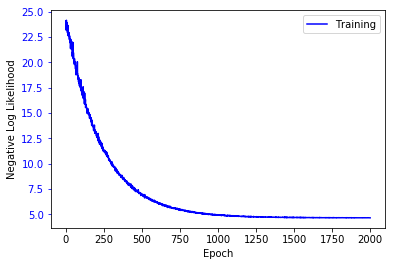

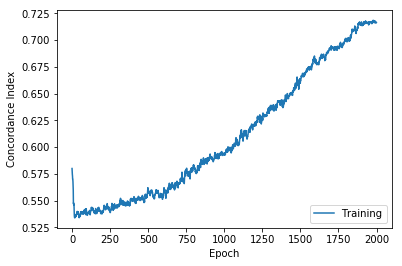

In [13]:
# Initialize empty lists to store the various train and out-of-bag concordance indices
train_list = []
oob_list = []

# The bootstrapping process is repeated 100 times
for i in range(100):
    # Generate a random number for n to be used as a random seed. The same seed (n) will be usedfor resampling the clinical
    # annotation and gene expression datasets
    n = random.randrange(0, 1000)
    
    # Resampling the datasets with the same random seed
    train_info_df = resample(model_info_df, replace=True, n_samples=176, random_state=n)
    train_data_df = resample(model_data_df, replace=True, n_samples=176, random_state=n)

    # Get a list of the rows that have been selected in the bootstrapping process
    used_rows = list(train_info_df.index.values)

    # Take the set difference between all the rows and the used ones. Subset the info and data files according
    # to these selected rows
    oob_info_df = model_info_df.loc[set(model_info_df.index.values) - set(used_rows)]
    oob_data_df = model_data_df.loc[set(model_data_df.index.values) - set(used_rows)]
    
    # Convert the data to the correct format for DeepSurv
    train_data = dataframe_to_deepsurv_ds(train_info_df, train_data_df, event_col = 'DMFS_Status', time_col = 'DMFS_Time')
    oob_data = dataframe_to_deepsurv_ds(oob_info_df, oob_data_df, event_col = 'DMFS_Status', time_col = 'DMFS_Time') 
    
    # Manually chosen hyperparameters
    hyperparams = {
        'L2_reg': 10.0,
        'batch_norm': True,
        'dropout': 0.4,
        'hidden_layers_sizes': [25, 25],
        'learning_rate': 1e-05,
        'lr_decay': 0.001,
        'momentum': 0.9,
        'n_in': train_data['x'].shape[1],
        'standardize': True
    }
    # Create an instance of DeepSurv using the hyperparams defined above
    model = deepsurv.DeepSurv(**hyperparams)
    # changed the above thing from deep_surv to deepsurv

    # DeepSurv can now leverage TensorBoard to monitor training and validation
    # This section of code is optional. If you don't want to use the tensorboard logger
    # Uncomment the below line, and comment out the other three lines: 
    #logger = None

    experiment_name = 'test_experiment_sebastian'
    logdir = './logs/tensorboard/'
    logger = TensorboardLogger(experiment_name, logdir=logdir)

    # Now we train the model
    update_fn=lasagne.updates.nesterov_momentum # The type of optimizer to use. \
                                                # Check out http://lasagne.readthedocs.io/en/latest/modules/updates.html \
                                                # for other optimizers to use
    n_epochs = 2000
    metrics = model.train(train_data, n_epochs=n_epochs, logger=logger, update_fn=update_fn)
    # Print the final metrics
    train_index = metrics['c-index'][-1]
    print('Train C-Index:', train_index)
    train_list.append(train_index)
    # print('Valid C-Index: ',metrics['valid_c-index'][-1])

    # Plot the training / validation curves
    viz.plot_log(metrics)
    test_index = model.get_concordance_index(**oob_data)
    print(hyperparams)
    print('Test C-Index:', test_index)
    oob_list.append(test_index)

In [14]:
# Use a list comprehension to extract concordance indices from the train list
new_train_list = [x[1] for x in train_list]

In [15]:
# Find the mean train concordance index
statistics.mean(new_train_list)

0.716412213740458

In [16]:
# Find the mean out-of-bag concordance index
statistics.mean(oob_list)

0.5040983606557377

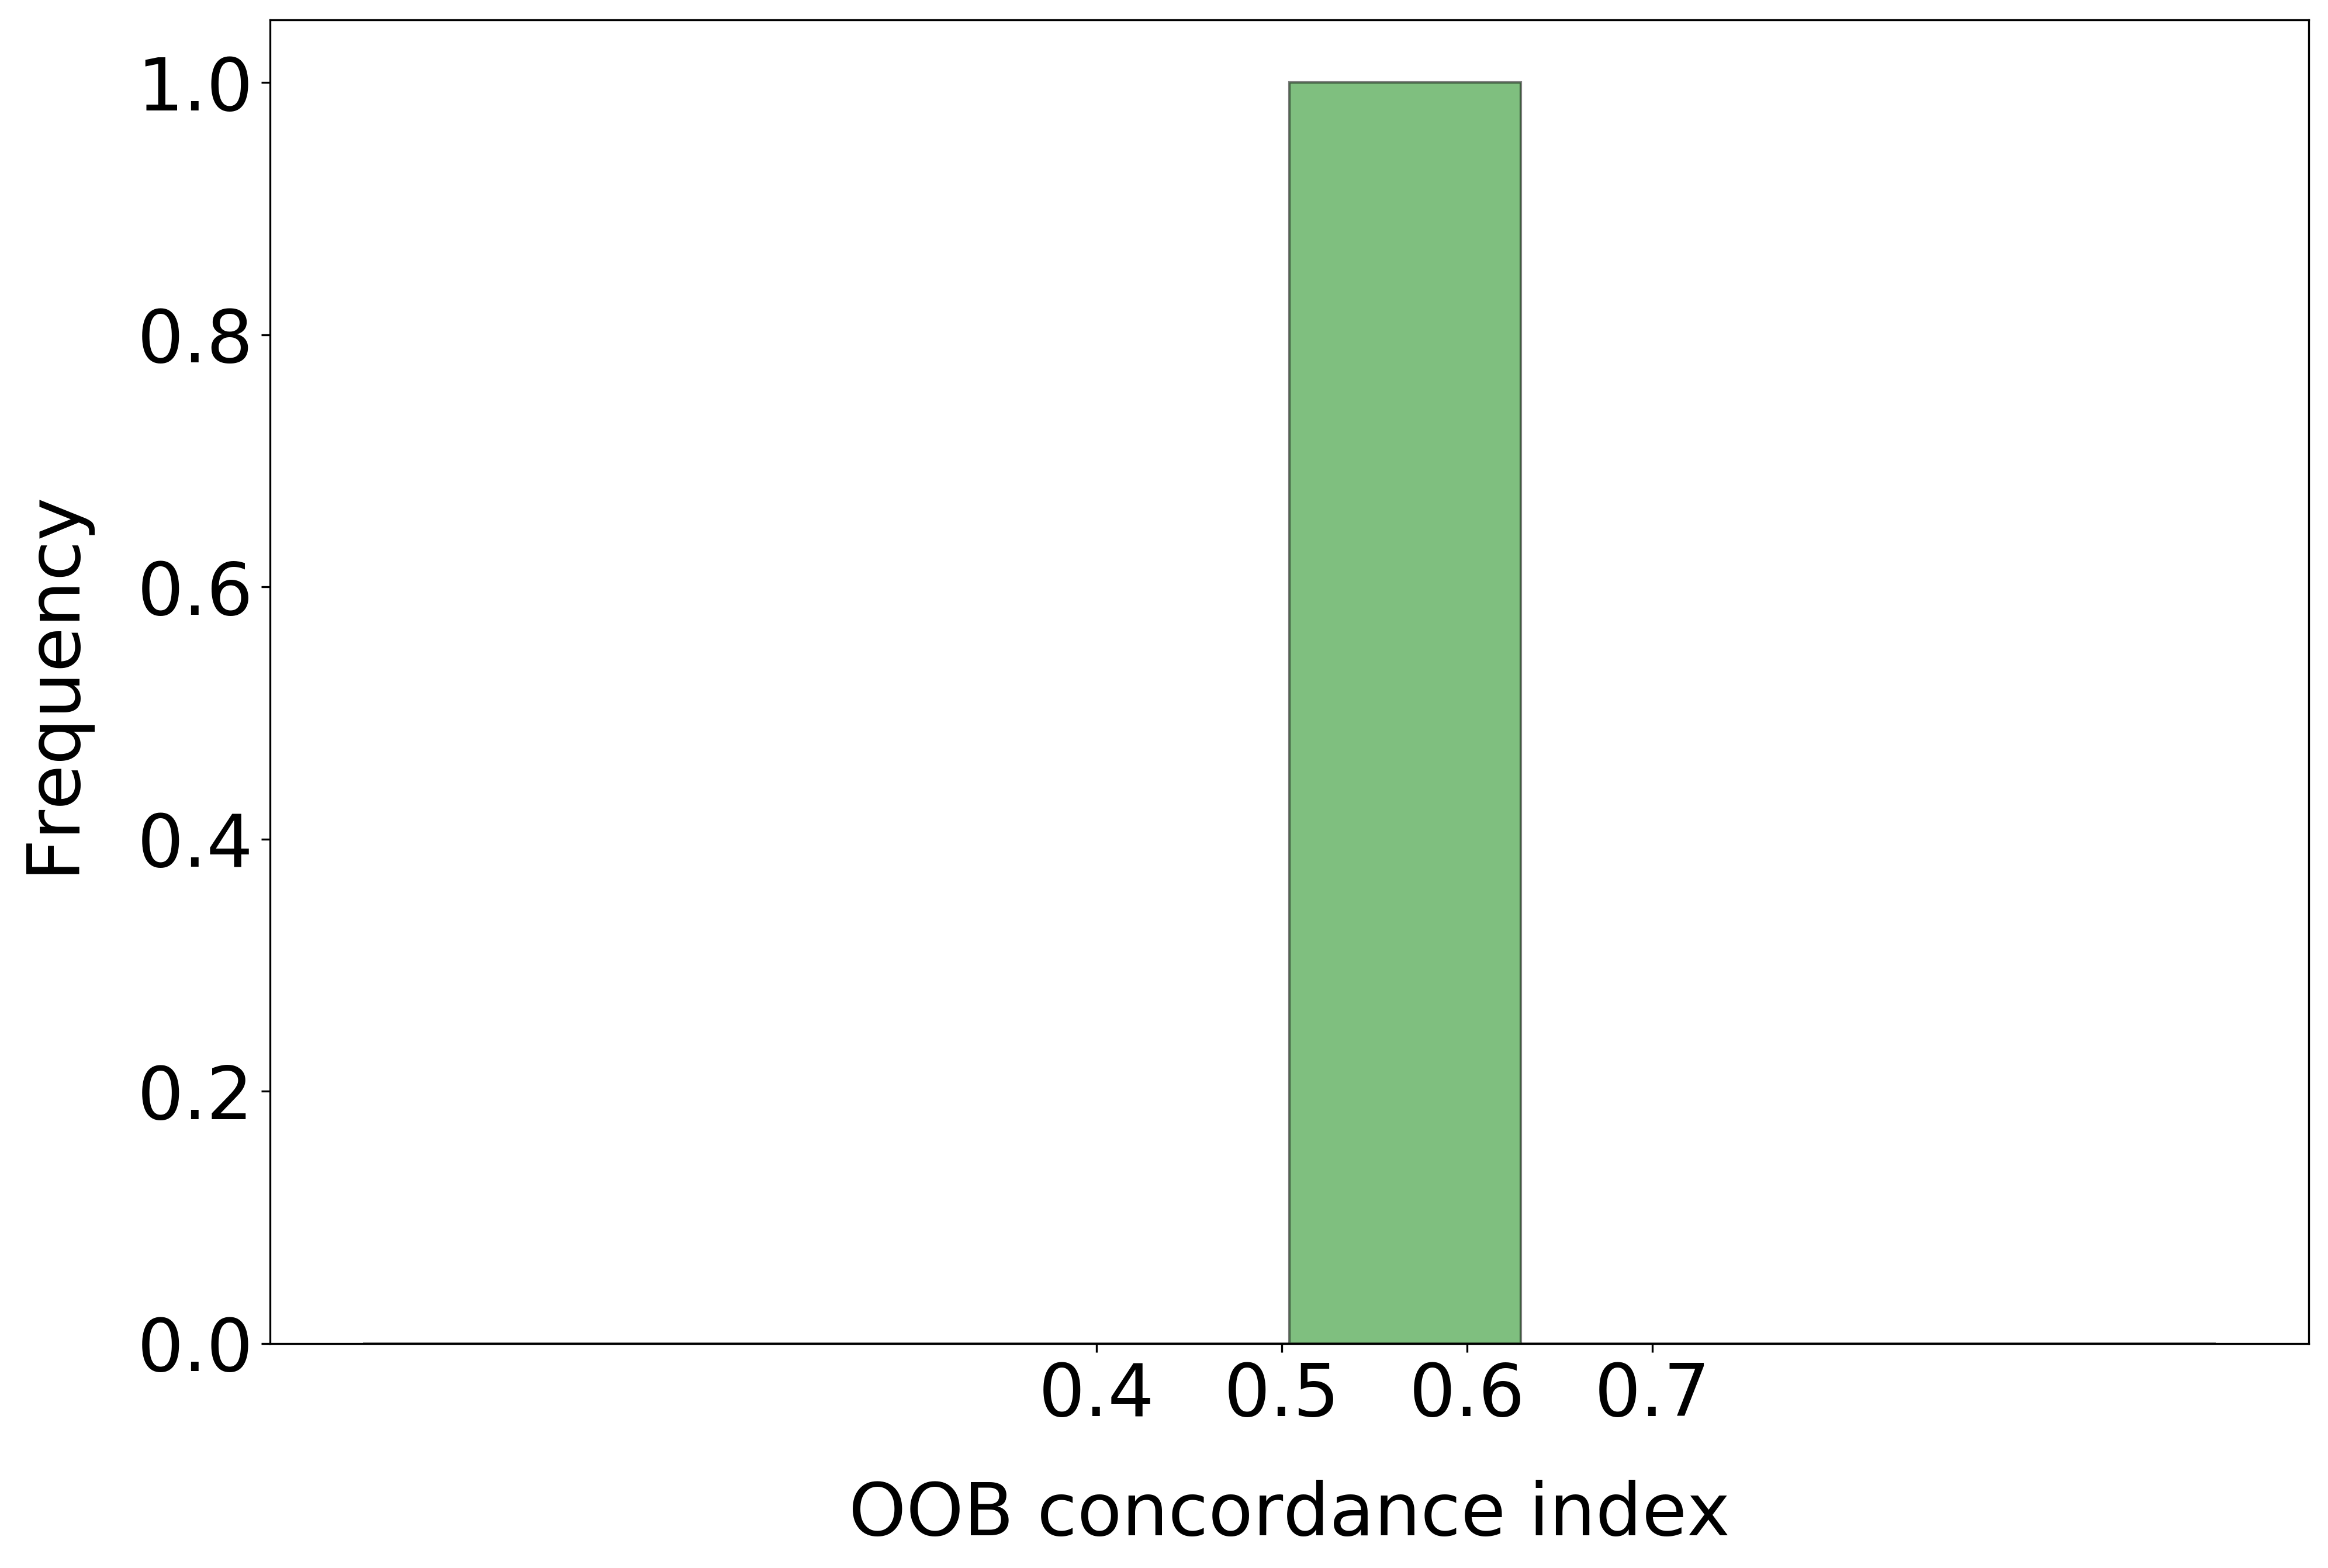

In [17]:
# Create a formatted plot of the histogram of oob concordance indices
# I tried to match the style to what R outputs as a histogram (as closely as possible)
plt.rcParams.update({'font.size': 30}) # Set font size
plt.figure(figsize=(15,10), dpi = 300) # Set figure size & resolution
plt.xlabel("x",labelpad=20)            # Set x-label padding
plt.ylabel("y",labelpad=20)            # Set y-label padding
plt.ylabel("Frequency")                # Set x-label
plt.xlabel("OOB concordance index")    # Set y-label
num_bins = 8                           # Choose the number of histogram bins
plt.xticks([0.4, 0.5, 0.6, 0.7])       # Set tick marks

# Create the histogram
n, bins, patches = plt.hist(oob_list, num_bins, facecolor = 'green', edgecolor = 'black', alpha=0.5)
plt.show()


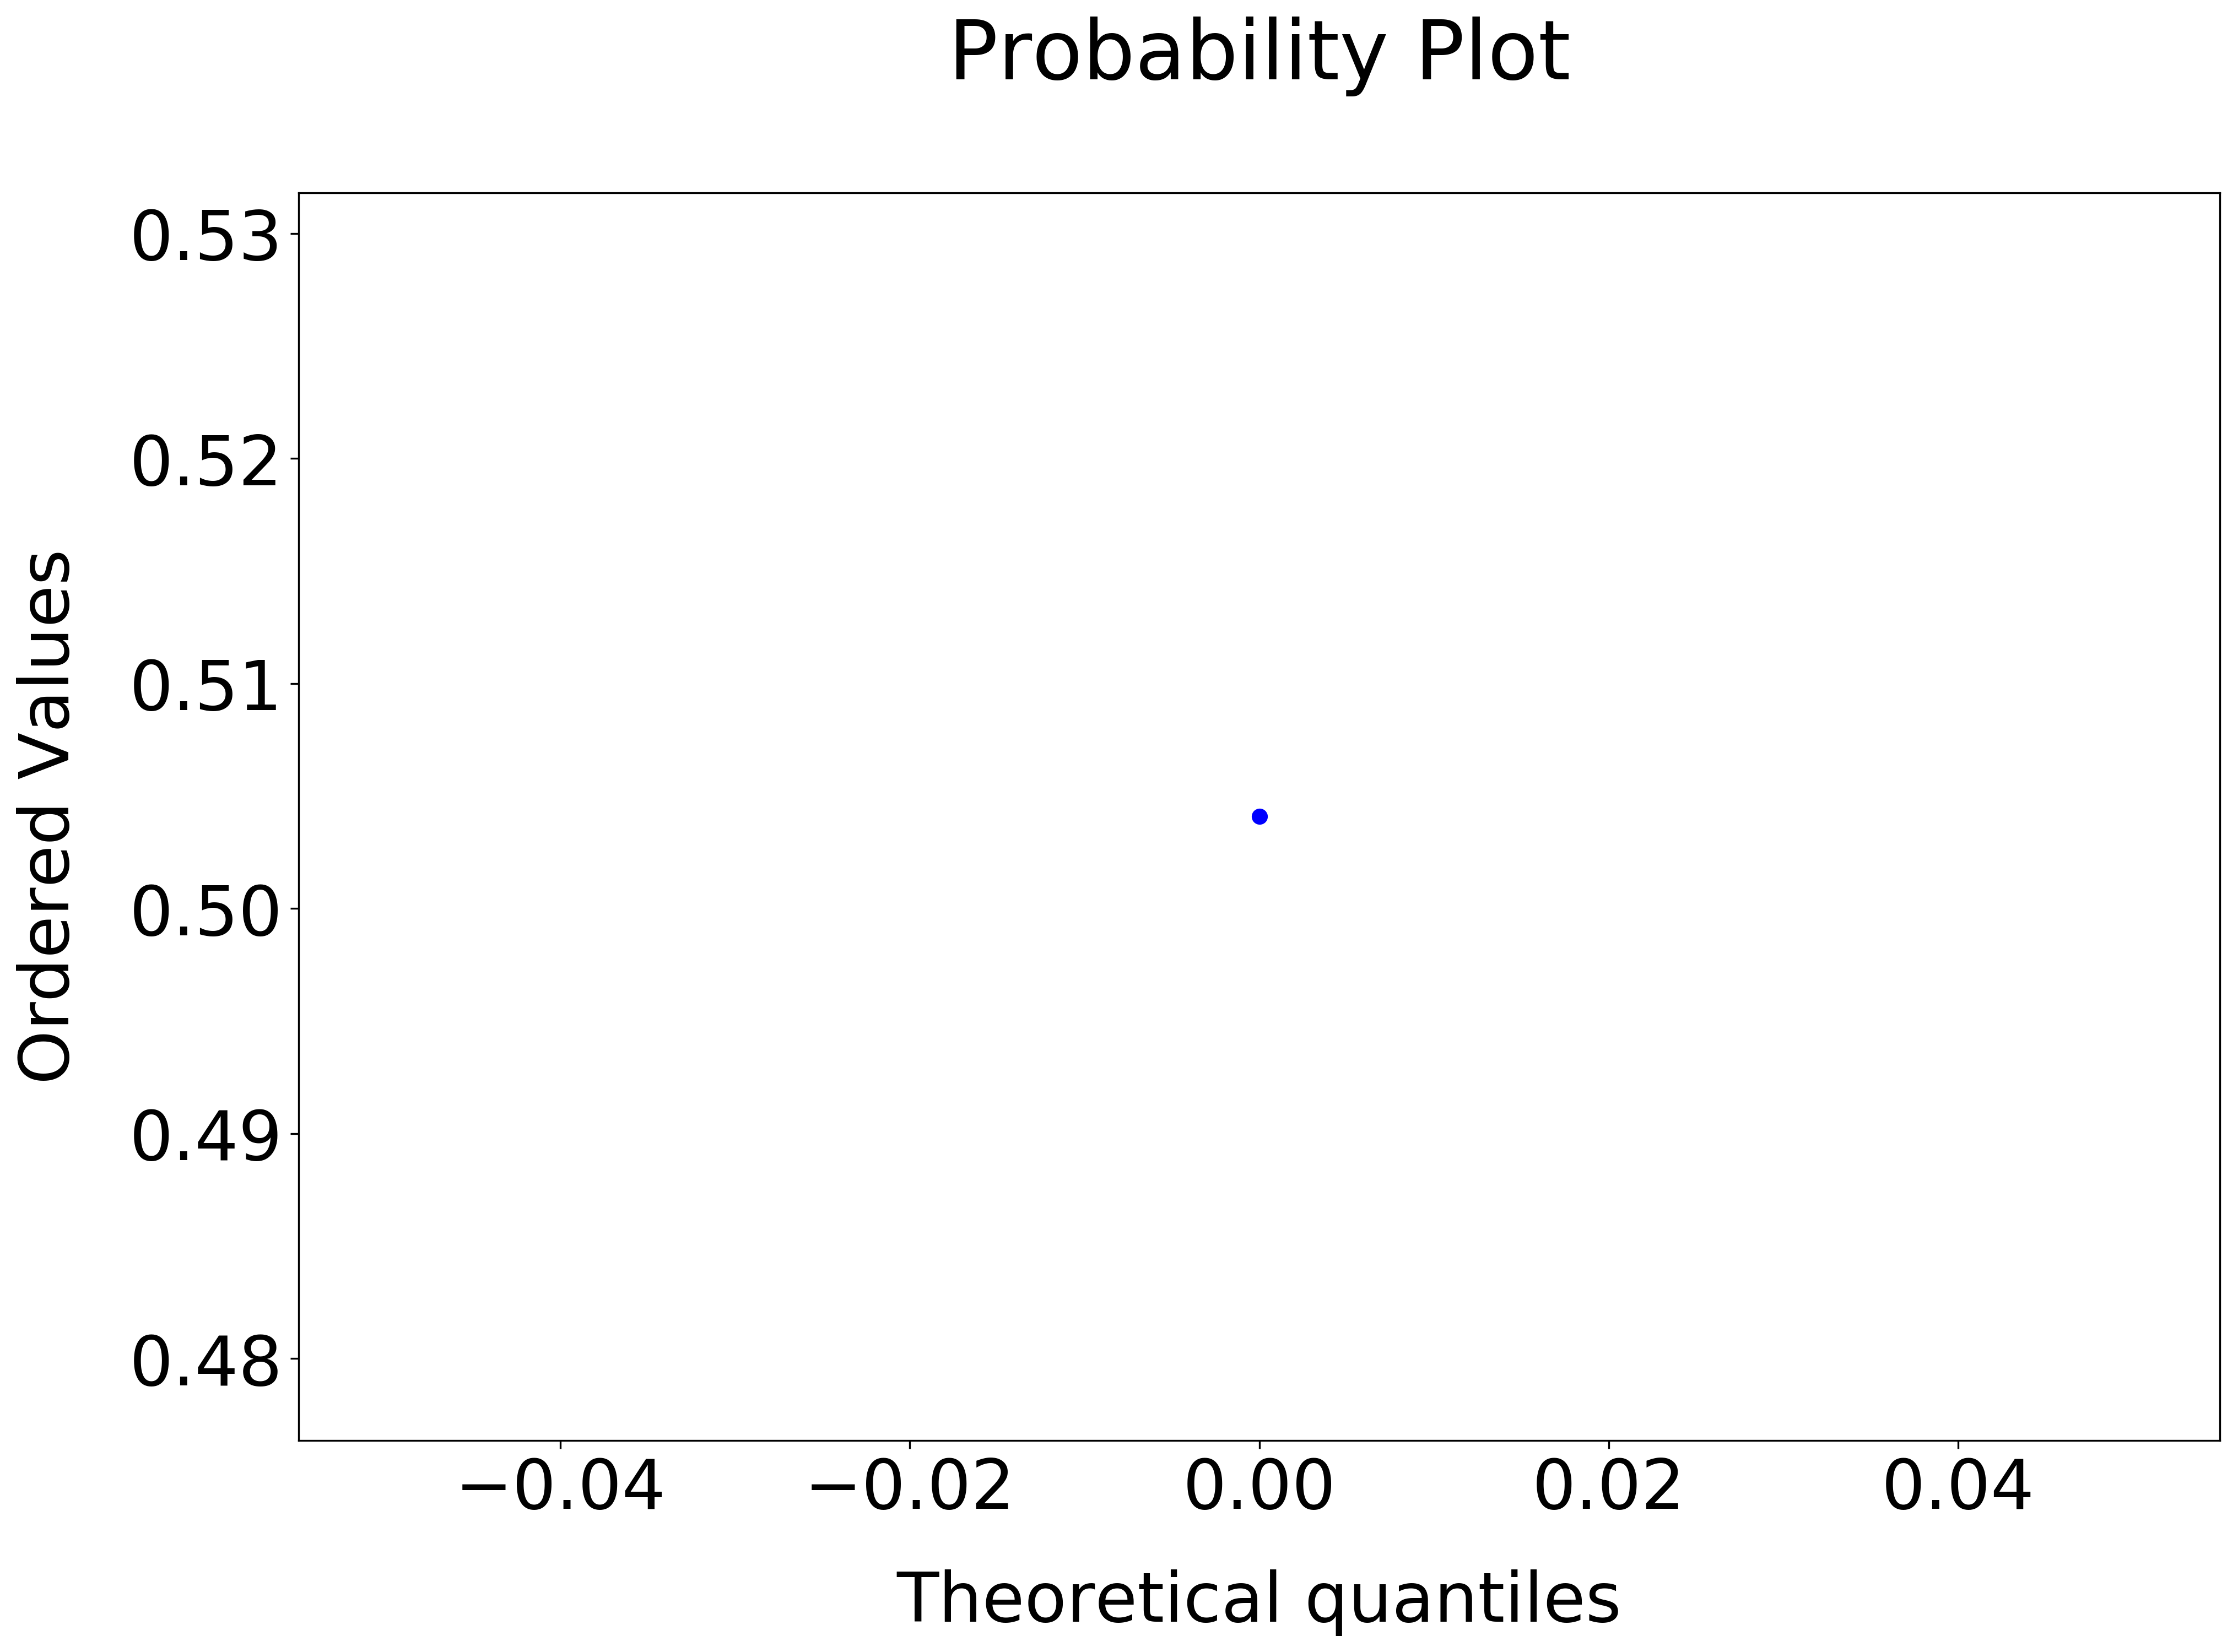

In [18]:
plt.rcParams.update({'font.size': 30}) # Set the font size
plt.figure(figsize=(15,10), dpi = 300) # Set the figure size & resolution
plt.xlabel("x",labelpad=20)            # Set the x-label padding
plt.ylabel("y",labelpad=20)            # Set the y-label padding
plt.title("", y=1.08)                  # Make the titel higher above the plot


# Create the quantile-quantiles plot against a normal distribution
stats.probplot(oob_list, dist="norm", plot=pylab)
pylab.show()
